<a href="https://colab.research.google.com/github/ortrsa/ML_project/blob/main/Improved_ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/Amazon_logo.svg/603px-Amazon_logo.svg.png" />

מגישים: אוריה שמלה - 312573744 , אור טרבלסי - 206066326


# Import data and libraries:

## Import libraries

In [38]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# ignor wornings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import warnings
warnings.filterwarnings("ignore")  
import pickle 

# tensorflow lib
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GRU, Dense, Flatten, Bidirectional 
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


# nlp tools
import string
import re
import nltk 

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Import data from google Drive


In [39]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/ML_proj/Reviews.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Identify whether a review is positive or negative according to 5 models

## Data processing

We first checked whether the data ןis balanced, and saw that there is much more 1 (positive reviews) than 0 (negative reviews) so  we artificially balanced it because we wanted that the model won't be biased towards the positive reviews.

We took 100,000 of each type of review and combined it into one table, then mixed the table, went through all the reviews and performed the following:

In [22]:
org_df = df # save the original df for later use
df.loc[(df.Score <= 3)  , "Score"] = 0
df.loc[(df.Score >= 4)  , "Score"] = 1
df["Score"] = df["Score"].astype(int)

In [24]:
# balance the data!
good = df[df['Score'] == 1]
bad =  df[df['Score'] == 0]

#Set data size ans suffel 
datasize = 200000
result = pd.concat([bad[:int(datasize/2)],good[:int(datasize/2)]])
data = result.sample(frac=1).reset_index(drop=True)
data.shape

(200000, 12)

In [26]:
# use NLP 
stop_words = stopwords.words('english')
stop_words = stop_words[:100]

ps = PorterStemmer()
count = 0
def Deal_with_sentence(x):
    global count 
    x = re.sub('\d', ' ', x) #Removes Digits
    x = re.sub('<.*?>', ' ', x) #Removes Html tags
    x = x.translate(str.maketrans('', '', string.punctuation)) #Removes Punctuations
    token_sen = word_tokenize(x)
    x = " ".join([ps.stem(word) for word in token_sen if word.lower() not in stop_words])
    count += 1
    return x

score = data['Score'].copy()
Reviews = data[['Text']].copy()['Text']
Reviews = Reviews.apply(Deal_with_sentence)


# Reviews = pd.read_pickle("/content/drive/MyDrive/ML_proj/Reviews.pkl") 
# score = pd.read_pickle("/content/drive/MyDrive/ML_proj/score.pkl")

In [31]:
model = CountVectorizer(stop_words = 'english')
vectors = model.fit_transform(Reviews)



In [29]:
X_train, X_test, y_train, y_test = train_test_split(data, score, random_state=0)

## Modeling

In [32]:
x_train, x_test, y_train, y_test = train_test_split(vectors, score, train_size=0.8, random_state=1)

In [33]:
def get_score(clf_model, x_score):
  y_true = np.array(y_test, dtype=np.int)
  y_pred = np.squeeze(np.array(clf_model.predict(x_score) >= 0.5, dtype=np.int))
  f1 = f1_score(y_true, y_pred)
  print("F1 score:", round(f1*100,2) , "%")
  acc = np.mean(np.array(y_pred == y_true, dtype=np.int))
  print("Test accuracy score:", round(acc*100,2) , "%")

  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm,fmt=".0f", annot=True)
  plt.xlabel("Predict")
  plt.ylabel("Test")
  plt.title("Confusion Matrix")
  plt.show()

### XGBOOST

F1 score: 78.71 %
Test accuracy score: 79.19 %


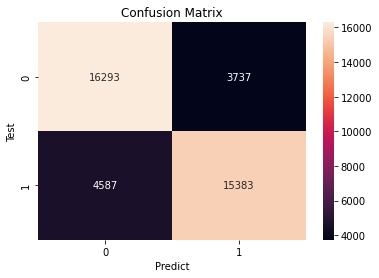

In [34]:
XG_clf = XGBClassifier(n_estimators= 100, n_jobs=-1, learning_rate=0.2, seed=0, eval_metric = 'mlogloss')
XG_clf.fit(x_train, y_train)
XG_clf.score(x_test, y_test)

# XG_clf = pickle.load(open("/content/drive/MyDrive/ML_proj/xgb.pkl", "rb"))

get_score(XG_clf, x_test)

### ADABOOST

F1 score: 73.03 %
Test accuracy score: 74.38 %


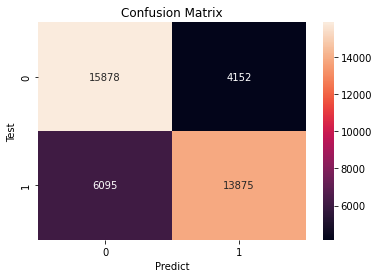

In [35]:
Ada = AdaBoostClassifier(n_estimators=50,algorithm="SAMME.R",learning_rate=0.37)
Ada.fit(x_train, y_train)

#pickle.dump(Ada, open("/content/drive/MyDrive/ML_proj/Ada.pkl", "wb"))
# Ada = pickle.load(open("/content/drive/MyDrive/ML_proj/Ada.pkl", "rb"))

get_score(Ada, x_test)

### LogisticRegression


F1 score: 85.74 %
Test accuracy score: 85.72 %


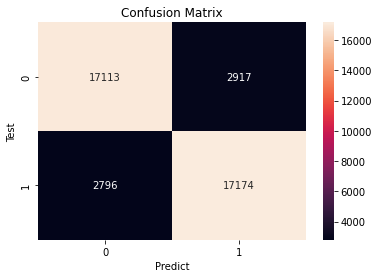

In [36]:
LR = LogisticRegression().fit(x_train, y_train)

# pickle.dump(LR, open("/content/drive/MyDrive/ML_proj/LR.pkl", "wb"))
# LR = pickle.load(open("/content/drive/MyDrive/ML_proj/LR.pkl", "rb"))

get_score(LR, x_test)
